In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Case Study: Detecting Fraudulent Insurance Claims
### Objective: To build a machine learning model that can identify potentially fraudulent insurance claims.


In [38]:
data = pd.read_excel('Worksheet - Fraud Detection ML model business case.xlsx')
EXTRACTION_DATE = '2024-11-11'


## Data Exploration and Preprocessing

In [39]:
def clean_dates(dates):
    return dates.str.replace('--','-', regex=True).replace(' ', '-', regex=True)

In [40]:
data = data.drop_duplicates()

data['Claim type'] = data['Claim type'].astype('category')
data['Claim status'] = data['Claim status'].astype('category')
data['Beneficiary gender'] = data['Beneficiary gender'].astype('category')

data['Claim amount'] = data['Claim amount'].replace('O', '0', regex=True).astype(float)

data['Claim date'] = clean_dates(data['Claim date'])
data['Event date'] = clean_dates(data['Event date'])

data['Claim date'] = pd.to_datetime(data['Claim date'])
data['Event date'] = pd.to_datetime(data['Event date'])

In [41]:
data.describe()

,Claim amount,Event date,Claim date,Beneficiary age,Beneficiary income
count,53317.000000,53317,53317,53317.000000,53317.000000
mean,26961.625911,2019-11-16 14:32:44.716694528,2019-12-21 23:44:21.732655872,48.015173,34302.823677
min,305.380000,2014-11-11 00:00:00,2014-11-15 00:00:00,18.000000,0.000000
25%,15205.340000,2017-05-20 00:00:00,2017-06-25 00:00:00,33.000000,21700.000000
50%,24098.230000,2019-11-24 00:00:00,2019-12-30 00:00:00,48.000000,32950.000000
75%,35648.120000,2022-05-13 00:00:00,2022-06-19 00:00:00,63.000000,45550.000000
max,69990.060000,2024-11-08 00:00:00,2025-02-02 00:00:00,78.000000,114150.000000
std,15926.438717,NaN,NaN,17.626903,17051.048410


What becomes apparent is that there are claims with a claim date in the future, which is not possible

In [42]:
null_data = data[data.isnull().any(axis=1)]
null_data

,Claim number,Policy number,Claim type,Claim amount,Event date,Claim date,Beneficiary gender,Beneficiary age,Beneficiary income,Claim status
9020,NaN,NaN,theft,18371.03,2020-05-11,2020-05-27,female,39,24950,Approved
30159,NaN,NaN,accident,19626.79,2022-02-03,2022-03-23,female,39,20450,Approved
37880,NaN,NaN,theft,27497.93,2017-11-12,2018-01-29,male,58,6000,Approved


As we can see, three rows have missing values. These are missing the policy number and claim number. Since these are unique identifiers, we can drop them for our analysis. However, it is worth noting that these three claims were actually approved. This could be a potential red flag for fraud, but we will not consider it in this analysis as we assume it to be a data entry error.

In [43]:
data = data.dropna() 

In [44]:
future_claims = data[data['Claim date'] > pd.to_datetime(EXTRACTION_DATE)] # claims made after 11th November 2024
future_approved_claims = future_claims[future_claims['Claim status'] == 'Approved']
print(len(future_approved_claims), len(future_approved_claims) / len(future_claims))
print(len(future_claims))

438 0.8521400778210116
514


We observe that **514** claims have a future claim date, **85% (438)** of which are approved. This is a clear indication of fraud. 

In [45]:
duplicate_claim_numbers = data[data.duplicated(subset='Claim number')]

<Axes: title={'center': 'Claim amount distribution'}, xlabel='Claim amount', ylabel='Count'>

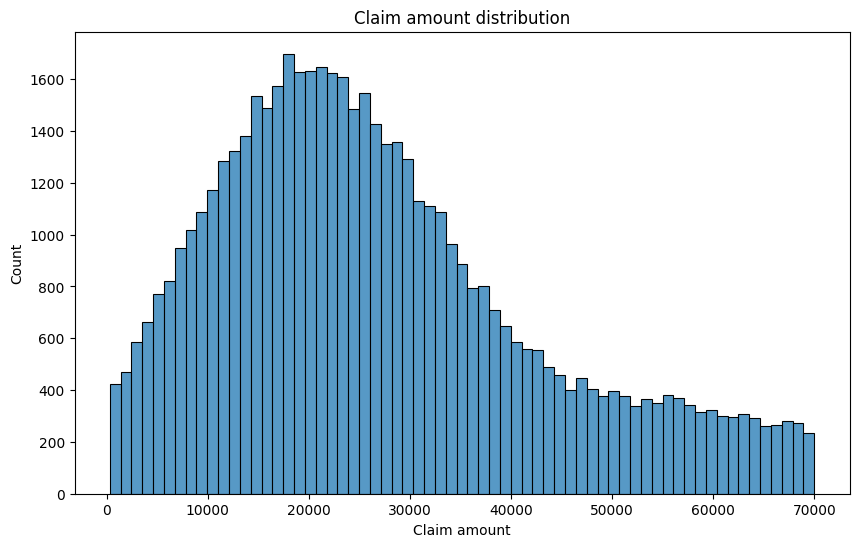

In [46]:
plt.figure(figsize=(10, 6))
plt.title('Claim amount distribution')
sns.histplot(data['Claim amount'])

We observe that our claim amount is a bell curve that is skewed to the right. This is a first indicator that fraudulent claims are likely to be on the higher end of the claim amount.

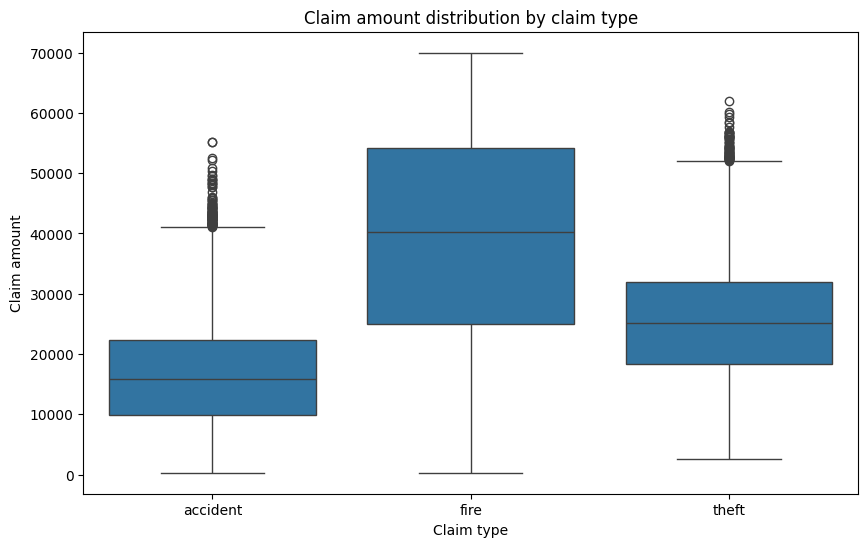

In [47]:
plt.figure(figsize=(10, 6))
plt.title('Claim amount distribution by claim type')
sns.boxplot(x='Claim type', y='Claim amount', data=data)
plt.show()
# accident_outliers of the boxplot using the IQR method 
Q1 = np.percentile(data[data['Claim type']== 'accident']['Claim amount'], 25)
Q3 = np.percentile(data[data['Claim type']== 'accident']['Claim amount'], 75)
IQR = Q3 - Q1
accident_outliers = data[(data['Claim type']== 'accident') & ((data['Claim amount'] > (Q3 + 1.5 * IQR)))]
accident_outliers

Q1 = np.percentile(data[data['Claim type']== 'theft']['Claim amount'], 25)
Q3 = np.percentile(data[data['Claim type']== 'theft']['Claim amount'], 75)
IQR = Q3 - Q1
theft_outliers = data[(data['Claim type']== 'theft') & ((data['Claim amount'] > (Q3 + 1.5 * IQR)))]

Here we observe that fire claims have the highest average claim amount. At the same time, accident and theft claims have some outliers that are significantly higher than the rest. This is a good indicator that these types of claims are more likely to be fraudulent.

## Feature Engineering


We create a new feature called 'Warning'. This feature takes the values Future Claim or Reused Claim or None:
- If it is 'Future Claim', it means that the claim was filed for a future date. 
- If it is 'Reused Claim', it means that the claim was filed for an incident that had already been claimed before. 

In [48]:
data['Warning'] = np.nan
data['Warning'] = data['Warning'].astype('category')
data['Warning'] = data['Warning'].cat.add_categories(['Future claim','Reused claim'])
data.loc[data['Claim date'] > pd.to_datetime(EXTRACTION_DATE), 'Warning'] = 'Future claim'
data.loc[data.duplicated(subset='Claim number', keep=False), 'Warning'] = 'Reused claim'

We create a new feature called 'Days between claim and event' which is the difference between the claim date and the event date. This feature could help in identifying fraudulent claims. For example, if the claim is filed after a long time from the incident date, it could be a potential red flag for fraud.

In [49]:
data['Days between claim and event'] = (data['Claim date'] - data['Event date']).dt.days


We create the 'Amount to income ratio' feature which is the ratio of the claim amount to the annual income. The idea is to reduce the multi-collinearity between the claim amount and the annual income. This feature could help in identifying fraudulent claims. For example, if the claim amount is very high compared to the annual income, it could be a potential red flag for fraud.

In [50]:
data['Amount to income ratio'] = data['Claim amount'] / data['Beneficiary income'] 
data['Amount to income ratio'] = data['Amount to income ratio'].replace(np.inf, 0)

Per claim type we also check how much the claim amount is compared to the average claim amount for that claim type

In [51]:
data['Mean claim amount per type'] = data.groupby('Claim type')['Claim amount'].transform('mean')
data['Claim amount deviation'] = data['Claim amount'] - data['Mean claim amount per type']

/var/folders/v9/05xy48h15_36s17mc3cb21z00000gn/T/ipykernel_26688/3008163914.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['Mean claim amount per type'] = data.groupby('Claim type')['Claim amount'].transform('mean')


Lastly a target variable 'Fraudulent' is created. This is the variable we want to predict. It takes the value 1 if the claim is fraudulent and 0 otherwise. In our case a claim is considered fraudulent if it is either a future claim or a reused claim or the claim status is Rejected fraud

In [52]:
data['Fraudulent'] = 0
data.loc[data['Warning'] == 'Future claim', 'Fraudulent'] = 1
data.loc[data['Warning'] == 'Reused claim', 'Fraudulent'] = 1
data.loc[data['Claim status'] == 'Rejected fraud', 'Fraudulent'] = 1

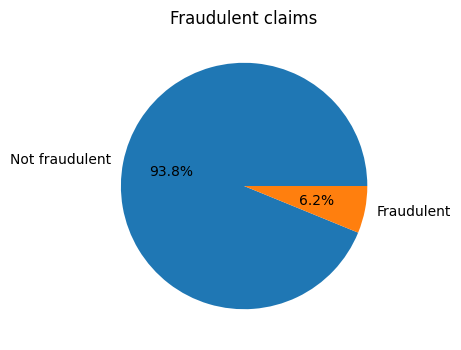

In [53]:
plt.figure(figsize=(8, 4))
plt.title('Fraudulent claims')
plt.axis('off')
pie_data = data['Fraudulent'].replace({0: 'Not fraudulent', 1: 'Fraudulent'})
pie_data.value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

What is very noticeable is that we have only 6.2% fraudulent claims in our dataset. This is a clear indication of class imbalance. This will be addressed later in the analysis.

In [54]:
model_data = data[['Claim type','Claim amount','Beneficiary gender', 'Beneficiary income', 'Warning', 'Days between claim and event', 'Amount to income ratio', 'Claim amount deviation', 'Fraudulent']]
X = model_data.drop(columns='Fraudulent')
y = model_data['Fraudulent']
X = pd.get_dummies(X, columns=['Claim type', 'Beneficiary gender', 'Warning'], drop_first=True)
encoded_feature_names = X.columns

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [58]:
scaler = MinMaxScaler()
smote = SMOTE(sampling_strategy='auto', random_state=42)
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)

In [59]:

# classifier = RandomForestClassifier()
# pipeline = Pipeline([
#     ('scaler', scaler),
#     ('oversample', smote),
#     ('undersample', undersample),
#     ('classifier', classifier)
# ])
# param_grid = {
#     'classifier__n_estimators': [100, 200, 300],
#     'classifier__max_depth': [10, 20, 30, 40, 50],
#     'classifier__min_samples_split': [2, 5, 10],
#     'classifier__min_samples_leaf': [1, 2, 4]
# }

# grid = GridSearchCV(pipeline, param_grid, cv=5)

# grid.fit(X_train, y_train)

# grid.best_params_

While running the GridSearchCV, we see that the model performs best with the following parameters:
`{'classifier__max_depth': 50,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 300}` 
For performance reasons the code is commented out, but the best parameters are used in the final model

In [60]:
classifier = RandomForestClassifier(max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=300, class_weight='balanced')

pipeline = Pipeline([
    ('scaler', scaler),
    ('oversample', smote),
    ('undersample', undersample),
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('oversample', SMOTE(random_state=42)),
                ('undersample', RandomUnderSampler(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=50,
                                        min_samples_split=5,
                                        n_estimators=300))])

## Model Evaluation and Interpretation

In [61]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92      5012
           1       0.10      0.18      0.13       320

    accuracy                           0.85      5332
   macro avg       0.52      0.54      0.52      5332
weighted avg       0.89      0.85      0.87      5332



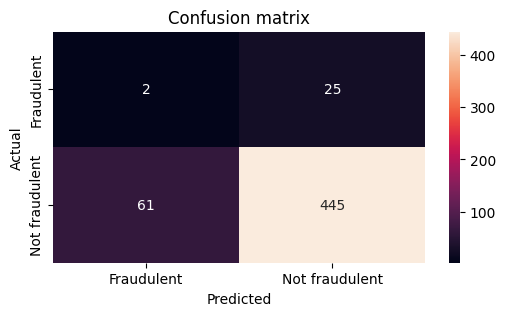

In [62]:
# plot the confusion matrix with tpr as a heatmap
plt.figure(figsize=(6, 3))
plt.title('Confusion matrix')

sns.heatmap(pd.crosstab(
                y_test.replace({0: 'Not fraudulent', 1: 'Fraudulent'}), 
                pd.Series(y_pred).replace({0: 'Not fraudulent', 1: 'Fraudulent'}), 
                rownames=['Actual'], colnames=['Predicted']
            ),
        annot=True, fmt='d'
    )
plt.show()

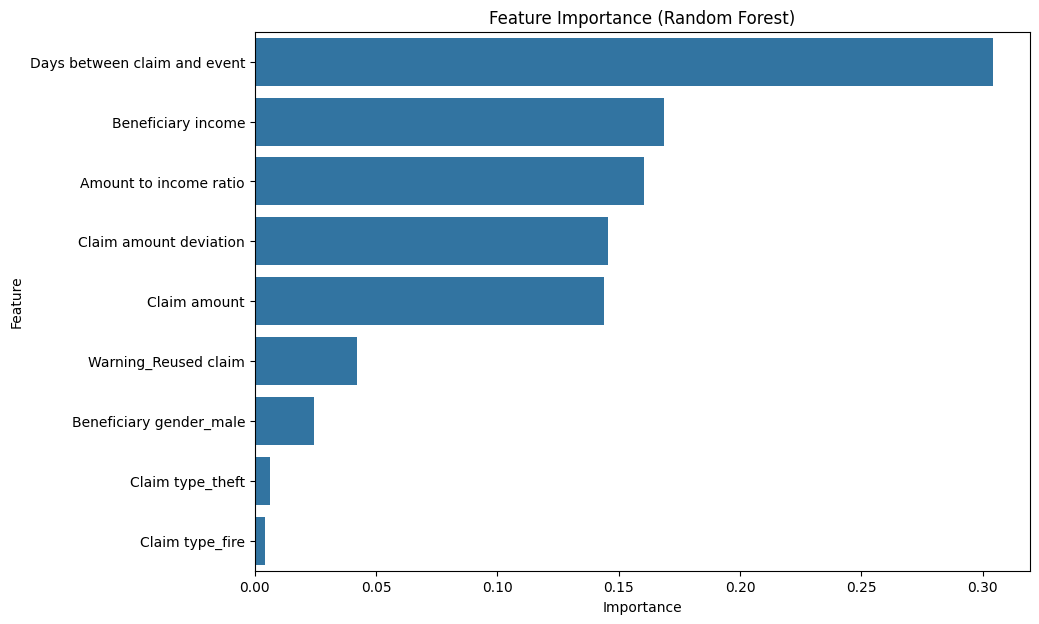

In [63]:
feature_importance = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Importance': pipeline.named_steps['classifier'].feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.show()
